# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Macros" data-toc-modified-id="Macros-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Macros</a></div><div class="lev1 toc-item"><a href="#Sum-Kernels" data-toc-modified-id="Sum-Kernels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sum Kernels</a></div><div class="lev1 toc-item"><a href="#Checking-derivatives" data-toc-modified-id="Checking-derivatives-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking derivatives</a></div><div class="lev1 toc-item"><a href="#mll-timing" data-toc-modified-id="mll-timing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>mll timing</a></div><div class="lev1 toc-item"><a href="#Optimizing-hyperparameters" data-toc-modified-id="Optimizing-hyperparameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimizing hyperparameters</a></div><div class="lev1 toc-item"><a href="#Updating-Cholesky" data-toc-modified-id="Updating-Cholesky-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Updating Cholesky</a></div><div class="lev1 toc-item"><a href="#Linear-Kernel" data-toc-modified-id="Linear-Kernel-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Linear Kernel</a></div>

In [1]:
using GaussianProcesses

In [ ]:
using PyPlot

In [5]:
# Simulate example
n = 10
x = 2π * rand(n)
μ = 0.2
y = μ + sin(x) + 0.05*randn(n)
mConst = MeanConst(0.0) # constant mean
kern = SE(0.0,0.0)
logObsVar = -1.0
gp = GP(x,y,mConst,kern, logObsVar)      # Fit the GP

GaussianProcesses.update_mll_and_dmll!(gp)

# Macros

In [7]:
prog = "1 + 1"

"1 + 1"

In [9]:
ex1 = parse(prog)

:(1 + 1)

In [10]:
typeof(prog)

String

In [14]:
ex1.typ

Any

In [15]:
ex2 = Expr(:call, :+, 1, 1)

:(1 + 1)

In [16]:
ex1 == ex2

true

In [102]:
dump(:(1+1))

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Int64 1
    3: Int64 1
  typ: Any


In [107]:
Symbol(:Var, :Sym, :($(2+3)))

:VarSym5

In [17]:
dump(ex2)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Int64 1
    3: Int64 1
  typ: Any


In [31]:
:( :a in $( :(:a + :b) ) )

:(:a in :a + :b)

In [77]:
i=3

3

In [80]:
Symbol(:b, :(a+$(i)))

Symbol("ba + 3")

In [72]:
:(a+$(1+1))

:(a + 2)

In [95]:
Expr("1+2")

LoadError: LoadError: TypeError: Expr: expected Symbol, got String
while loading In[95], in expression starting on line 1

In [114]:
i=3
:(a+b$i)

:((a + b) $ i)

In [124]:
"a"join(("b","c"))

"abc"

In [123]:
join("a", "b", "c")

"a"

In [140]:
parse("1+1")

:(1 + 1)

In [184]:
macro gen_grad_kern(kerntype, num_pars)
    inarray = ["dkdθ$i(k,r)" for i in 1:num_pars]
    array_str = "["join(inarray,", ")"]"
    esc(quote
        function asdfasdf(k::$kerntype, x::Vector{Float64}, y::Vector{Float64})
            println("in macro grad_kern")
            r = distance(k, x, y)
            dK_theta = $(parse(array_str))
            return dK_theta
        end
    end)
end

@gen_grad_kern (macro with 1 method)

In [10]:
[quote 
    $(1+i)+$i
end for i in 1:3]

3-element Array{Expr,1}:
 quote  # In[10], line 2:
    2 + 1
end
 quote  # In[10], line 2:
    3 + 2
end
 quote  # In[10], line 2:
    4 + 3
end

In [29]:
typeof(parse("1+1"))

Expr

In [30]:
"
    blah
    blih
"

"\n    blah\n    blih\n"

In [77]:
macro gen_dKdθi!(kerntype, num_pars)
    inarray = ["dkdθ$i(k,R[i,j])" for i in 1:num_pars]
    block_arrays = [" iparam==$iparam
        @inbounds for j in 1:nobsv
            @simd for i in 1:j
                    Kgrad[i,j] = $(inarray[iparam])
                    Kgrad[j,i] = Kgrad[i,j]
            end
        end\n" 
        for iparam in 1:num_pars
    ]
    ifstatements = ("    if"join(block_arrays,"    elseif")"    end")
    println(parse(ifstatements))
    esc(quote
        function dKdθi!(Kgrad::AbstractMatrix,  pe::$kerntype, X::Matrix{Float64}, data::IsotropicData, iparam::Int)
            1 <= iparam <= num_params(pe) || throw(ArgumentError, "iparam must be between 1 and %d", num_params(pe))
            d, nobsv = size(X)
            R = distance!(pe, X, data)

            $(parse(ifstatements))
            return Kgrad
        end
    end)
end

@gen_dKdθi! (macro with 1 method)

In [ ]:
macro gen_grad_stack!(kerntype)
    esc(quote
        function grad_stack!(stack::AbstractArray, k::$kerntype, X::Matrix{Float64}, data::KernelData)
            for iparam in 1:num_params(k)
                dKdθi!(Base.view(stack,:,:,iparam), k, X, data, iparam)
            end
            return stack
        end
    end)
end

In [78]:
@gen_dKdθi!(Periodic, 3)

if iparam == 1 # none, line 2:
    @inbounds for j = 1:nobsv # none, line 3:
            @simd for i = 1:j # none, line 4:
                    Kgrad[i,j] = dkdθ1(k,R[i,j]) # none, line 5:
                    Kgrad[j,i] = Kgrad[i,j]
                end
        end
else  # none, line 8:
    if iparam == 2 # none, line 9:
        @inbounds for j = 1:nobsv # none, line 10:
                @simd for i = 1:j # none, line 11:
                        Kgrad[i,j] = dkdθ2(k,R[i,j]) # none, line 12:
                        Kgrad[j,i] = Kgrad[i,j]
                    end
            end
    else  # none, line 15:
        if iparam == 3 # none, line 16:
            @inbounds for j = 1:nobsv # none, line 17:
                    @simd for i = 1:j # none, line 18:
                            Kgrad[i,j] = dkdθ3(k,R[i,j]) # none, line 19:
                            Kgrad[j,i] = Kgrad[i,j]
                        end
                end
        end
    end
end


LoadError: LoadError: UndefVarError: IsotropicData not defined
while loading In[78], in expression starting on line 15

In [2]:
k1 = Periodic(log(0.5), log(√(10.0)), log(24.0))
GaussianProcesses.grad_kern(k1, [1.0, 2.0, 3.0], [4.4, 5.5, 6.6])

3-element Array{Float64,1}:
 1.39342
 0.34263
 1.0877 

In [164]:
macroexpand(:(@gen_grad_kern(Periodic, 3)))

quote  # In[161], line 5:
    function #280#asdfasdf(#283#k::Periodic,#284#x::Vector{Float64},#285#y::Vector{Float64}) # In[161], line 6:
        println("in macro grad_kern") # In[161], line 7:
        #281#r = distance(#283#k,#284#x,#285#y) # In[161], line 8:
        #282#dK_theta = [dkdθ1(#283#k,#281#r),dkdθ2(#283#k,#281#r),dkdθ3(#283#k,#281#r)] # In[161], line 9:
        return #282#dK_theta
    end
end

# Sum Kernels

In [3]:
k1 = Periodic(log(0.5), log(√(10.0)), log(24.0))
k2 = SE(log(5.0*24), log(√40.0))
k3 = SE(log(200.0*24), log(√80.0))
k4 = SE(log(0.5*24), log(√10.0))
k5 = Noise(log(√1.0))
k6 = SE(log(20.0*24), 0.0)
_k=(k1+k2+k3+k4+k5)*k6

Type: GaussianProcesses.ProdKernel
  Type: GaussianProcesses.SumKernel
    Type: GaussianProcesses.Periodic, Params: [-0.693147,1.15129,3.17805]
    Type: GaussianProcesses.SEIso, Params: [4.78749,1.84444]
    Type: GaussianProcesses.SEIso, Params: [8.47637,2.19101]
    Type: GaussianProcesses.SEIso, Params: [2.48491,1.15129]
    Type: GaussianProcesses.Noise, Params: [0.0]
  Type: GaussianProcesses.SEIso, Params: [6.17379,0.0]


In [10]:
gp2=GaussianProcesses.GP(x,y,mConst, _k, logObsVar)

GP object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.ProdKernel
      Type: GaussianProcesses.SumKernel
        Type: GaussianProcesses.Periodic, Params: [-0.693147,1.15129,3.17805]
        Type: GaussianProcesses.SEIso, Params: [4.78749,1.84444]
        Type: GaussianProcesses.SEIso, Params: [8.47637,2.19101]
        Type: GaussianProcesses.SEIso, Params: [2.48491,1.15129]
        Type: GaussianProcesses.Noise, Params: [0.0]
      Type: GaussianProcesses.SEIso, Params: [6.17379,0.0]
  Input observations = 
[2.02392 2.43558 6.02094 3.53654 1.35737 6.10887 3.83164 5.755 4.24817 0.844245]
  Output observations = [1.04139,0.786694,-0.0587062,-0.247649,1.25824,0.00791292,-0.415704,-0.351884,-0.603731,0.947892]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -16.891

In [4]:
GaussianProcesses.num_params(_k)

12

In [11]:
GaussianProcesses.set_params!(_k, GaussianProcesses.get_params(_k))
GaussianProcesses.update_mll_and_dmll!(gp2)

# Checking derivatives

In [6]:
prev_mLL=gp.mLL
prev_dmLL=gp.dmLL

prev_params=GaussianProcesses.get_params(gp)

dθ=[1.0, 0.0, 1.0, 1.0]*1e-4 # select mean parameters
GaussianProcesses.set_params!(gp, prev_params.+dθ)
GaussianProcesses.update_mll_and_dmll!(gp)

println("change in log likelihood: ", gp.mLL-prev_mLL)
println("expected change in log likelihood: ", dot(prev_dmLL, dθ))

change in log likelihood: -0.0005331052146200221
expected change in log likelihood: -0.0005330724996024072


In [7]:
# Training data
n = 10
x = 2π * rand(n)
μ = 0.2
y = μ + sin(x) + 0.05*randn(n)

# Select mean and covariance function
mConst = MeanConst(0.0)                   # constant mean
kern = SE(0.0,0.0)                   # Squared exponential kernel with parameters
                                     # log(ℓ) = 0.0, log(σ) = 0.0

Type: GaussianProcesses.SEIso, Params: [0.0,0.0]


In [8]:
mZero = MeanZero()

Type: GaussianProcesses.MeanConst, Params: [0.0]


In [9]:
logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
gp = GP(x,y,mZero,kern, logObsNoise)      # Fit the GP

GP object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
  Input observations = 
[5.1877 1.25477 4.2079 4.77396 6.23273 4.25078 5.05695 3.28277 3.24286 3.10401]
  Output observations = [-0.736578,1.21941,-0.678843,-0.80676,0.245601,-0.723342,-0.765713,0.0192677,0.0536838,0.265152]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -6.354

In [10]:
GaussianProcesses.update_mll_and_dmll!(gp)
prev_mLL=gp.mLL
prev_dmLL=gp.dmLL

prev_params=GaussianProcesses.get_params(gp)

dθ=[0.0, 1.0, 0.0, 0.0]*1e-5
GaussianProcesses.set_params!(gp, prev_params.+dθ)

GaussianProcesses.get_params(gp).-prev_params

GaussianProcesses.update_mll_and_dmll!(gp)

println("change in log likelihood ", gp.mLL-prev_mLL)

println("expected change in log likelihood ", dot(prev_dmLL, dθ))

# reset parameter to what they were before
GaussianProcesses.set_params!(gp, prev_params)
GaussianProcesses.update_mll_and_dmll!(gp)

change in log likelihood 7.789098631860725e-6
expected change in log likelihood 7.789234749557313e-6


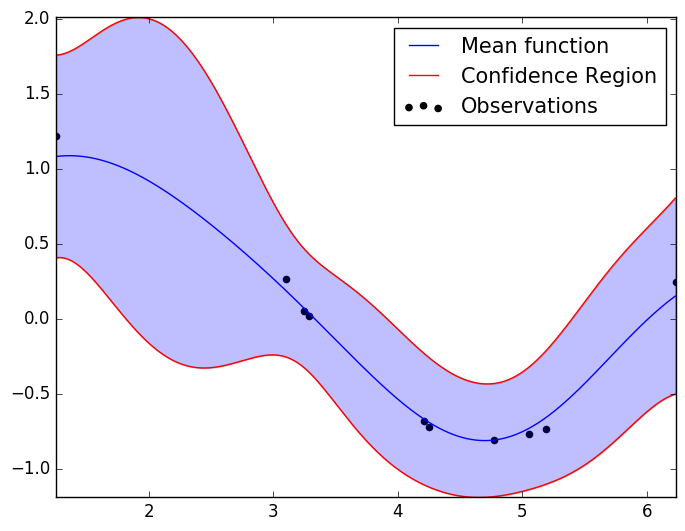

In [11]:
plot(gp)

In [12]:
Pkg.build("IJulia")

INFO: Building Homebrew


Already up-to-date.


INFO: Building Nettle
INFO: Building ZMQ
INFO: Building IJulia
INFO: Found Jupyter version 4.1.1: jupyter
Writing IJulia kernelspec to /Users/imolk/.julia/v0.5/IJulia/deps/julia-0.5/kernel.json ...
Installing julia kernelspec julia-0.5
[InstallKernelSpec] Removing existing kernelspec in /Users/imolk/Library/Jupyter/kernels/julia-0.5
[InstallKernelSpec] Installed kernelspec julia-0.5 in /Users/imolk/Library/Jupyter/kernels/julia-0.5


# mll timing

# Optimizing hyperparameters

In [13]:
optimize!(gp)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.0,0.0,0.0,0.0]
 * Minimizer: [-4.144653037524202,0.4147885886908506, ...]
 * Minimum: -5.810760e+00
 * Iterations: 23
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 82
 * Gradient Calls: 59

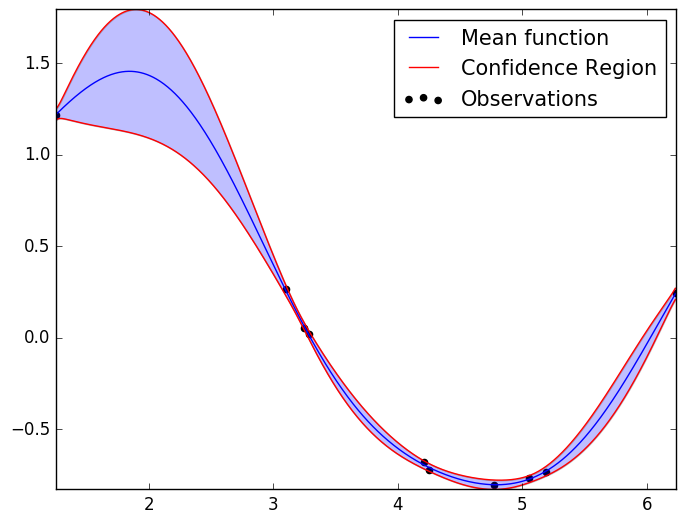

In [14]:
plot(gp)

# Updating Cholesky

In [15]:
import Base.LinAlg
LinAlg = Base.LinAlg

Base.LinAlg

In [16]:
gp.cK.chol

Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.827781 0.002107 0.571157 0.774547 0.542757 0.589576 0.822033 0.203789 0.192051 0.154742; 0.0 0.827779 0.0270683 0.00495877 -0.00132371 0.0243457 0.0010214 0.168532 0.179355 0.220534; 0.0 0.0 0.598555 0.271867 -0.282902 0.579871 0.0818546 0.620217 0.607322 0.557198; 0.0 0.0 0.0 0.106594 -0.397007 0.0172873 0.0483245 -0.34771 -0.353935 -0.366786; 0.0 0.0 0.0 0.0 0.391135 0.00312971 -0.00561206 -0.125754 -0.130391 -0.143296; 0.0 0.0 0.0 0.0 0.0 0.0216881 -0.000813361 -0.0226763 -0.0249344 -0.032363; 0.0 0.0 0.0 0.0 0.0 0.0 0.0203866 0.0366992 0.0386263 0.0445512; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.303384 0.319945 0.376951; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0240852 0.0242984; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0373029]

In [17]:
?LinAlg.lowrankupdate

```
lowrankupdate(C::Cholesky, v::StridedVector) -> CC::Cholesky
```

Update a Cholesky factorization `C` with the vector `v`. If `A = C[:U]'C[:U]` then `CC = cholfact(C[:U]'C[:U] + v*v')` but the computation of `CC` only uses `O(n^2)` operations.


In [18]:
methods(LinAlg.lowrankupdate)

# 1 method for generic function "lowrankupdate":
lowrankupdate(C::Base.LinAlg.Cholesky, v::Union{Base.ReshapedArray{T<:Any,1,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N<:Any}}},DenseArray{T<:Any,1},SubArray{T<:Any,1,A<:Union{Base.ReshapedArray{T<:Any,N<:Any,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N<:Any}}},DenseArray},I<:Tuple{Vararg{Union{Base.AbstractCartesianIndex,Colon,Int64,Range{Int64}},N<:Any}},L<:Any}}) at linalg/cholesky.jl:551

In [19]:
gp.cK.chol

Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.827781 0.002107 0.571157 0.774547 0.542757 0.589576 0.822033 0.203789 0.192051 0.154742; 0.0 0.827779 0.0270683 0.00495877 -0.00132371 0.0243457 0.0010214 0.168532 0.179355 0.220534; 0.0 0.0 0.598555 0.271867 -0.282902 0.579871 0.0818546 0.620217 0.607322 0.557198; 0.0 0.0 0.0 0.106594 -0.397007 0.0172873 0.0483245 -0.34771 -0.353935 -0.366786; 0.0 0.0 0.0 0.0 0.391135 0.00312971 -0.00561206 -0.125754 -0.130391 -0.143296; 0.0 0.0 0.0 0.0 0.0 0.0216881 -0.000813361 -0.0226763 -0.0249344 -0.032363; 0.0 0.0 0.0 0.0 0.0 0.0 0.0203866 0.0366992 0.0386263 0.0445512; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.303384 0.319945 0.376951; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0240852 0.0242984; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0373029]

In [20]:
LinAlg.lowrankupdate(gp.cK.chol, randn(n))

Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.995716 0.705043 0.0477388 0.253165 0.167547 -0.0545443 1.51466 -0.219772 -0.0543405 -0.0739818; 0.0 1.33773 -0.734471 -0.794246 -0.571113 -0.882381 0.618559 -0.442016 -0.22433 -0.169194; 0.0 0.0 0.856769 0.64209 0.123036 0.924599 -0.290508 0.83592 0.71408 0.685494; 0.0 0.0 0.0 0.268996 0.316004 0.0916344 -0.346323 -0.184274 -0.27942 -0.24582; 0.0 0.0 0.0 0.0 0.690299 0.0188468 -0.169712 0.175265 0.144387 0.160557; 0.0 0.0 0.0 0.0 0.0 0.0235439 -0.0435128 0.0854005 0.0772477 0.0808261; 0.0 0.0 0.0 0.0 0.0 0.0 0.102953 -0.24801 -0.234399 -0.260241; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.315762 0.331457 0.389352; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0246711 0.0259583; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0376126]

# Linear Kernel

In [21]:
k = LinIso(1.0)

Type: GaussianProcesses.LinIso, Params: [1.0]


In [22]:
D = randn(2000,50);

In [23]:
GaussianProcesses.grad_stack(k, D');
@time gs=GaussianProcesses.grad_stack(k, D');

  0.208845 seconds (152 allocations: 63.332 MB, 89.87% gc time)


In [24]:
ell = exp(k.ll)

2.718281828459045

In [25]:
X=D';

In [26]:
stack = Array(Float64, 2000, 2000, 1);

In [27]:
@time stack[:,:,1] = X' * X;

  0.042819 seconds (224 allocations: 30.532 MB, 4.74% gc time)


In [28]:
@time Base.LinAlg.BLAS.gemm!('T', 'N', -2.0/ell^2, X, X, 0.0, @view(stack[:,:,1]));

  0.064882 seconds (53.78 k allocations: 2.247 MB)


In [29]:
gs[10,20,1]

-1.9378308033888367

In [30]:
GaussianProcesses.grad_kern(k, D[10,:], D[20,:])

1-element Array{Float64,1}:
 -1.93783

In [31]:
GaussianProcesses.cov(k, D')[10,20]
@time GaussianProcesses.cov(k, D')[10,20]

  0.042274 seconds (16 allocations: 32.807 MB, 73.26% gc time)


0.9689154016944184

In [32]:
GaussianProcesses.cov(k, D[10,:], D[20,:])

0.9689154016944184

In [33]:
@assert issymmetric(GaussianProcesses.cov(k, D'))

LoadError: LoadError: AssertionError: issymmetric(GaussianProcesses.cov(k,D'))
while loading In[33], in expression starting on line 1

In [34]:
mat=GaussianProcesses.cov(k, D');

In [35]:
issymmetric(mat)

false

In [36]:
methods(Base.LinAlg.copytri!)

# 2 methods for generic function "copytri!":
copytri!(A::AbstractArray{T<:Any,2}, uplo::Char) at linalg/matmul.jl:200
copytri!(A::AbstractArray{T<:Any,2}, uplo::Char, conjugate::Bool) at linalg/matmul.jl:200

In [37]:
Base.LinAlg.copytri!(mat, 'U');

In [38]:
issymmetric(mat)

true

In [39]:
k=LinArd(randn(50))

Type: GaussianProcesses.LinArd, Params: [-1.83053,0.702697,0.146815,0.211462,0.342764,-1.77563,-1.28504,-2.10494,2.28994,0.556233,-1.8737,0.5513,0.241587,-0.570517,0.176188,-0.77589,-2.52825,0.43079,-1.33702,-0.179666,0.263395,-1.22524,0.333214,0.375885,-0.695029,-2.11762,0.308911,0.290946,-0.905062,0.621092,-0.426527,-1.41091,-1.23688,0.509521,0.399751,-0.0159841,-0.19424,0.97771,-1.26295,-0.847359,-1.20433,-0.198976,0.717195,-0.348773,-0.220668,-0.709438,0.694147,-1.32192,0.643331,1.49063]


In [40]:
GaussianProcesses.grad_stack(k, D');
@time gs=GaussianProcesses.grad_stack(k, D');

  1.389580 seconds (1.11 k allocations: 2.984 GB, 31.65% gc time)


In [41]:
gs[290,890,5]

0.6943398834848901

In [42]:
GaussianProcesses.grad_kern(k, D[290,:], D[890,:])[5]

0.6943398834848902

In [43]:
Kb=GaussianProcesses.cov(k, D')
@time GaussianProcesses.cov(k, D')[290,890]

  0.010051 seconds (22 allocations: 32.808 MB, 13.75% gc time)


-142.1483503397153

In [44]:
GaussianProcesses.cov(k, D[290,:], D[890,:])

-142.14835033971528

In [45]:
@assert issymmetric(GaussianProcesses.cov(k, D'))

In [46]:
?Base.LinAlg.issymmetric

```
issymmetric(A) -> Bool
```

Test whether a matrix is symmetric.


In [47]:
peakflops()

5.7155888072953255e10

In [48]:
import PkgDev

In [49]:
# PkgDev.submit("GaussianProcesses")

In [50]:
mat = [[1,2] [3,4]]

2×2 Array{Int64,2}:
 1  3
 2  4

In [51]:
Base.LinAlg.copytri!(mat, 'U')

2×2 Array{Int64,2}:
 1  3
 3  4

In [52]:
mat = reshape(collect(1:12), 2,2,3)

2×2×3 Array{Int64,3}:
[:, :, 1] =
 1  3
 2  4

[:, :, 2] =
 5  7
 6  8

[:, :, 3] =
  9  11
 10  12

In [53]:
Base.LinAlg.copytri!(@view(mat[:,:,1]), 'U')

2×2 SubArray{Int64,2,Array{Int64,3},Tuple{Colon,Colon,Int64},true}:
 1  3
 3  4

In [54]:
mat

2×2×3 Array{Int64,3}:
[:, :, 1] =
 1  3
 3  4

[:, :, 2] =
 5  7
 6  8

[:, :, 3] =
  9  11
 10  12

In [55]:
@time DDt = D * D';

  0.041146 seconds (1.77 k allocations: 30.605 MB, 15.82% gc time)


In [56]:
@time Base.LinAlg.copytri!(DDt,'U');

  0.018828 seconds (4 allocations: 160 bytes)


In [57]:
DDt2 = reshape(DDt, 2000, 2000, 1);

In [58]:
@time Base.LinAlg.copytri!(@view(DDt2[:,:,1]),'U');

  0.137118 seconds (111.83 k allocations: 3.337 MB)


In [60]:
A = randn(10000,10000);
AtA = A'A;
@time cholfact(AtA);

  4.850667 seconds (22 allocations: 762.940 MB, 1.24% gc time)
